<center><h1><font face="vollkorn" color=navy> Title Here </font></h1><center>
<center><h2> Subtitle Here </h2></center>
<p>
<img src="http://www.berkeley.edu/brand/img/logos/primarylogo.png" style="float: center; width: 75%; margin-left: 20%;">
<p style="clear: both;">
<center><h1><font face="vollkorn" color=navy>Contributors:</center>
<p>
<h2>Name 1</h2>
<h2>Name 2</h2>

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV
import numpy as np

ImportError: No module named seaborn

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
raw_data_path = '/Users/choldgraf/gdrive/Projects/BIDS/Sourcing/data/raw_data/POData_Sample PO Data.csv'
data_path = '/Users/choldgraf/gdrive/Projects/BIDS/Sourcing/data/modified_data/UCB_dept_merge.csv'

### Raw data

In [4]:
raw_data = pd.read_csv(raw_data_path)
raw_data.head(3)

,PO ID,PO #,Creation Date,Original Revision Date,Last Revision Date,Last Distribution Date,Workflow Completion Date,PO Closed Date,Supplier ID,Supplier Name,...,SS,RFx Status,Shared Cart,Qty Net Received,Qty Net Invoiced,Qty Variance,Cost Net Invoiced,Cost Variance,Receive Status,Voucher Status
0,44934666,B000580513,2/2/2015,2/2/2015,2/2/2015,NaN,NaN,NaN,13894854,INNOVIVE INC,...,NaN,NaN,F,0,0,0,0,1105.00,none,none
1,44934686,B000580511,2/2/2015,2/2/2015,2/2/2015,2/2/2015,2/2/2015,NaN,13895143,ERGOGENESIS WORKPLACE SOLUTIONS LLC,...,NaN,NaN,F,0,0,0,0,581.95,none,none
2,44934685,B000580512,2/2/2015,2/2/2015,2/2/2015,2/2/2015,2/2/2015,NaN,1376,LIFE TECHNOLOGIES CORPORATION,...,NaN,NaN,F,0,0,0,0,498.00,none,none


### Modified data
The first step was to select a subset of useful columns, and do some early data processing to have a reasonable data set.

In [5]:
# Parsing date columns allows us to do some nifty things with pandas
date_columns = ['po_closed_date', 'creation_date']

In [6]:
data = pd.read_csv(data_path, parse_dates=date_columns)

In [7]:
data.head(3)

,po_id,po_num,creation_date,supplier_name,item_type,product_description,manufacturer,quantity,unit_price,department,buyer__first_name,buyer__last_name,po_closed_date,department_name,spend
0,29847876,BB00195887,2013-05-31,GIVE SOMETHING BACK,SQ Hosted Product,"PORTABLE COMBINATION LAPTOP LOCK, 6 FT. CARBON...",KENSINGTON,30,24.32,NaN,Dustin,Miller,2013-07-16,UIAPA UB Academic Year,795.26
1,29847864,BB00195886,2013-05-31,GRAINGER INC,PunchOut Product,"Wall Mount Fan, Oscillating, Number of Speeds ...",AIR KING,1,35.58,NaN,Erin,Pinkston,2013-08-08,UKHDS Unit 1 Apt Admin,38.78
2,29847796,BB00195884,2013-05-31,BELLCO GLASS INC,NonCatalog Product,"Septum Stopper, 20mm Blue Butyl Rubber QtyPerC...",NaN,1,77.41,NaN,William,Wolf,NaT,CCHEM RES Research,104.67


## Counts
This allows us to start to make some quick slices of the data and see what's going on. It makes exploration and hypothesis formulation much easier.
### How many unique suppliers / manufacturers / etc

In [8]:
n_suppliers = data.supplier_name.unique().shape[0]
n_manufacturers = data.manufacturer.unique().shape[0]
n_departments = data.department_name.unique().shape[0]
print n_suppliers, n_manufacturers, n_departments

11570 11037 2830


In [9]:
# Figuring out what abbreviations might mean in department name
abbr = []
for nm in data.department_name.unique():
    abbr.append(nm.split(' ')[0])
abbr = np.array(abbr)
len(np.unique(abbr))

354

In [10]:
count_cutoff = 1000
count_name = 'department_name'

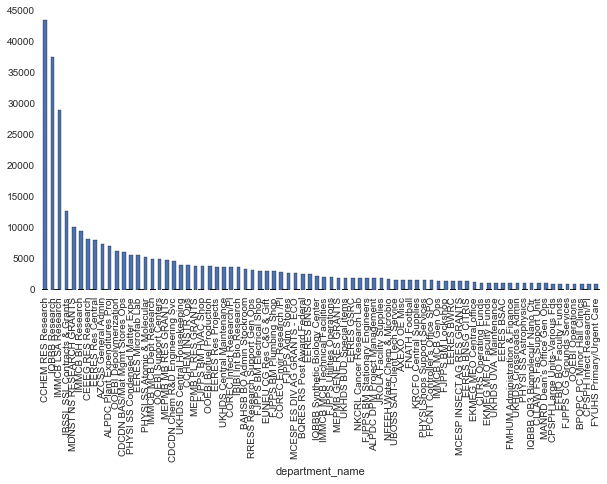

In [11]:
# Quickly count the number of POs per "count_name" and display
counts = data.groupby(count_name).count().iloc[:, 0].\
    sort(ascending=False, inplace=False)
counts[counts > count_cutoff].plot(kind='bar', figsize=(10, 5))

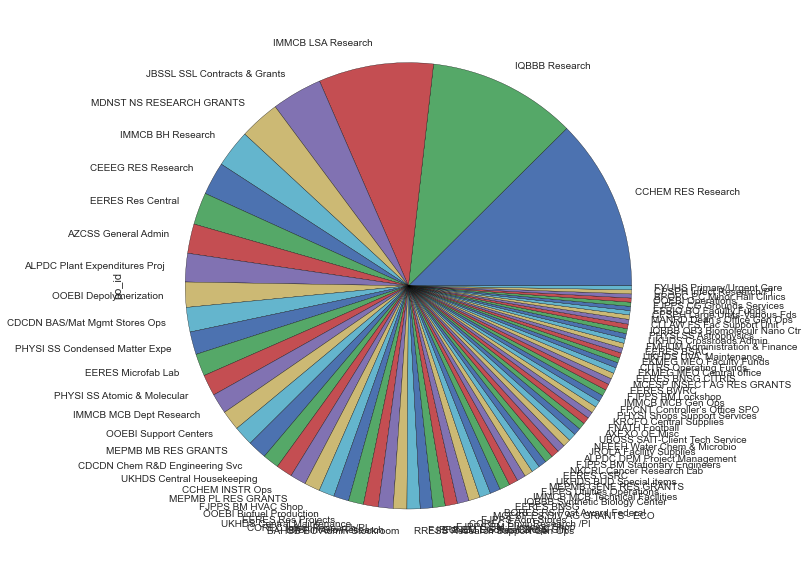

In [12]:
# Pie charts can show the percentage of counts
counts[counts > count_cutoff].plot(kind='pie', figsize=(10, 10))

## Can also ask more interesting questions w/ time values
### Seasonal changes in purchasing

In [14]:
week_counts = data.groupby(['creation_date', 'supplier_name'])\
    .count()['po_id'].unstack('supplier_name').resample('w', how='sum')
week_counts['week'] = week_counts.index.week

In [15]:
week_sums = week_counts.groupby('week').sum()
week_mean = week_sums.mean(1)
week_ste = week_sums.std(1) / np.sqrt((~np.isnan(week_sums)).sum(1))

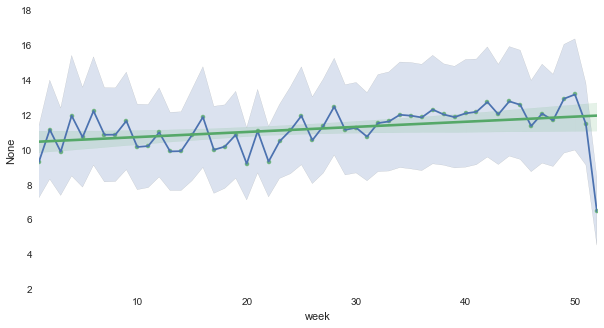

In [21]:
ax = week_mean.plot(figsize=(10, 5))
ax.fill_between(week_ste.index, week_mean-week_ste, week_mean+week_ste,
                alpha=.2)
sns.regplot(week_mean.index.values, week_mean, ax=ax)

## Time to complete
Finding questions to ask is more challenging than running the analyses themselves. For example, purchasing wants to reduce costs. What's a feature we can calculate that reflects "cost" for a PO?

In [24]:
# Datetime objects let us create "differences"
data['days_to_close'] = data['po_closed_date'] - data['creation_date']
data['days_to_close'] = data['days_to_close'].astype('timedelta64[D]')

In [28]:
use_depts = counts[counts > 2000].index.values

In [66]:
sort_grps = data.query('department_name in @use_depts').\
    groupby('department_name').median()['days_to_close'].copy()
sort_grps.sort(ascending=False)

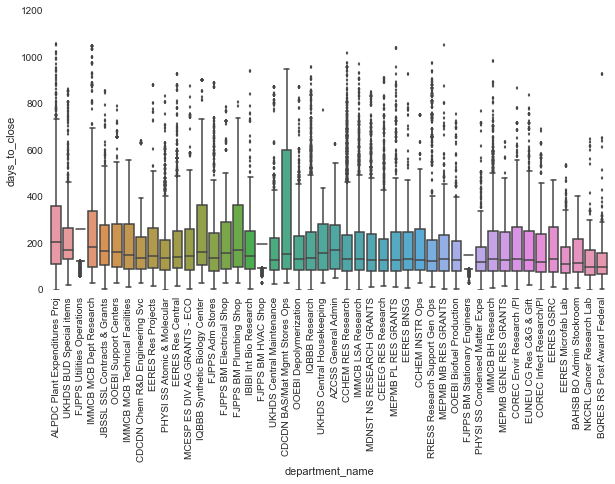

In [67]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data.query('department_name in @use_depts')['days_to_close'],
            groupby=data['department_name'], order=sort_grps.index, ax=ax)
_ = plt.xticks(rotation=90)

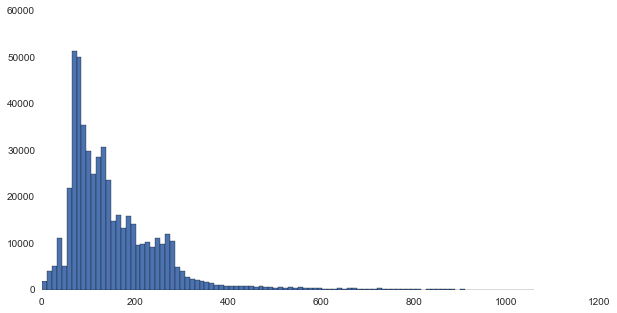

In [71]:
data.days_to_close.hist(bins=100, figsize=(10, 5))